In [3]:
import os
os.environ['USE_PYGEOS'] = '0'
os.environ['PROJ_LIB'] = '/home/jupyter-hanshilingyun/.conda/envs/python39/share/proj'
from osgeo import gdal, ogr, osr
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt


# 影像基本信息
dataset = gdal.Open('../2024 math/data/0.25 Degree Rain(1961-2022)/TIF/1990-01-01.tif')
basic_info(dataset)

Image size: 256x144 pixels, Bands: 1
Spatial Reference System:
 GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]
Geographic Extent: (72.125, 54.125) - (136.125, 18.125)


In [ ]:
raster_plot(dataset, True, cmap='RdYlBu')

In [1]:
import os
os.environ['USE_PYGEOS'] = '0'
os.environ['PROJ_LIB'] = '/home/jupyter-hanshilingyun/.conda/envs/python39/share/proj'
from osgeo import gdal, ogr, osr
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [2]:
# 获取栅格数据信息
def basic_info(dataset):
    # 获取图像的行数和列数（栅格尺寸）
    im_width = dataset.RasterXSize
    im_height = dataset.RasterYSize
    # 获取波段数量
    band_count = dataset.RasterCount
    print(f"Image size: {im_width}x{im_height} pixels, Bands: {band_count}")
    # 获取地理坐标系（SRS）信息
    srs = dataset.GetProjection()
    print("Spatial Reference System:\n", srs)
    # 获取地理坐标范围
    geotransform = dataset.GetGeoTransform()
    if geotransform is not None:
        min_x = geotransform[0]
        max_x = geotransform[0] + geotransform[1]*im_width
        min_y = geotransform[3] + geotransform[5]*im_height
        max_y = geotransform[3]
        print("Geographic Extent: ({}, {}) - ({}, {})".format(min_x, min_y, max_x, max_y))

# 获取无效值
def get_nodatavalue(dataset):
    band = dataset.GetRasterBand(1)
    return band.GetNoDataValue()

# 绘制栅格图像
def raster_plot(dataset, drop_na=True, cmap=None):
    band = dataset.GetRasterBand(1).ReadAsArray().astype(float)
    if drop_na: 
        array = np.ma.masked_where(band==get_nodatavalue(dataset), band)  # 去除NAN值
        # array = np.ma.masked_where(array==1, array)
    else: 
        array = band
    plt.imshow(array, cmap=cmap)
    plt.axis('off')
    plt.show()

# 获取每个栅格的值
def get_values(dataset):
    # 获取波段数据
    band = dataset.GetRasterBand(1)  # 处理第一个波段的数据，如果多余一个波段在嵌套一个循环
    array = band.ReadAsArray().astype(float)
    band.FlushCache()  # 释放资源
    # 将栅格数据转换为DataFrame，每一行包含 [行号, 列号, 值]
    df_data = []
    for row in range(len(array)):
        for col in range(len(array[0])):
            value = array[row, col]  # 获取当前行列位置的栅格值
            df_data.append([row, col, value])
    return pd.DataFrame(df_data, columns=['Row', 'Column', 'Value'])

# 栅格转数组
def raster2array(dataset):
    band = dataset.GetRasterBand(1)
    return band.ReadAsArray()

# 数组转栅格
def array2raster(dataset, newRasterfn, noDataValue, array):
    geotransform = dataset.GetGeoTransform()
    originX = geotransform[0]
    originY = geotransform[3]
    pixelWidth = geotransform[1]
    pixelHeight = geotransform[5]
    cols = dataset.RasterXSize
    rows = dataset.RasterYSize

    # 创建栅格对象
    driver = gdal.GetDriverByName('GTiff')
    outRaster = driver.Create(newRasterfn, cols, rows, 1, gdal.GDT_CInt32)  # 可以切换像素类型
    outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))
    outband = outRaster.GetRasterBand(1)

    # 根据条件替换值
    newArray = np.where((array >= 0) & (array < 0.2), 1,
                        np.where((array >= 0.2) & (array < 0.4), 2,
                                 np.where((array >= 0.4) & (array < 0.6), 3,
                                          np.where((array >= 0.6) & (array < 0.8), 4, 
                                                   np.where((array >=0.8) & (array <=1 ), 5, noDataValue)))))
    # 写出栅格
    outband.WriteArray(newArray)
    outRasterSRS = osr.SpatialReference()
    outRasterSRS.ImportFromWkt(dataset.GetProjectionRef())
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    outband.FlushCache()

# 栅格转矢量
def raster2shp(dataset, shpFilefn):
    band = dataset.GetRasterBand(1)  # 这个波段就是最后想要转为矢量的波段，如果是单波段数据的话那就都是1
    prj = osr.SpatialReference()
    prj.ImportFromWkt(dataset.GetProjection())  # 读取栅格数据的投影信息，用来为后面生成的矢量做准备

    driver = ogr.GetDriverByName("ESRI Shapefile")
    if os.path.exists(shpFilefn):  # 若文件已经存在，则删除它继续重新做一遍
        driver.DeleteDataSource(shpFilefn)
    outShp = driver.CreateDataSource(shpFilefn)  # 创建一个目标文件
    polygonLayer = outShp.CreateLayer(shpFilefn[:-4], srs=prj, geom_type=ogr.wkbMultiPolygon)  # 对shp文件创建一个图层，定义为多个面类
    newField = ogr.FieldDefn('value', ogr.OFTReal)  # 给目标shp文件添加一个字段，用来存储原始栅格的pixel value,浮点型，
    polygonLayer.CreateField(newField)

    gdal.Polygonize(band, None, polygonLayer, 0)  # 核心函数，执行的就是栅格转矢量操作
    outShp.SyncToDisk()
    outShp = None

In [3]:
# 影像基本信息
dataset = gdal.Open('青浦FVC_20201.tif')
basic_info(dataset)

Image size: 1747x1317 pixels, Bands: 1
Spatial Reference System:
 GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]
Geographic Extent: (120.84730090352352, 30.93932586123892) - (121.3181079439378, 31.294250230000006)


Warning 1: PROJ: proj_create_from_database: Cannot find proj.db


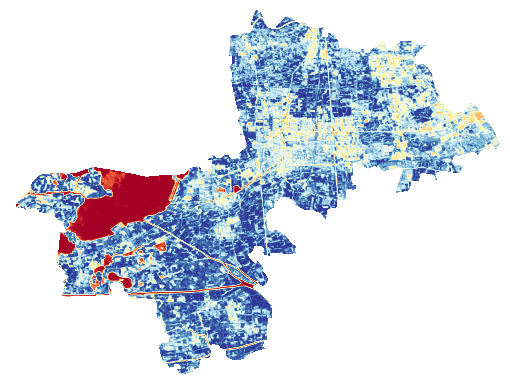

In [4]:
raster_plot(dataset, True, cmap='RdYlBu')

In [5]:
df = get_values(dataset)

In [6]:
 # 去除NAN值
df0 = df[df.Value!=get_nodatavalue(dataset)].copy() 
# df0 = df[(df.Value!=df.Value.min()) & (df.Value!=1)].copy() 

# 断点
min_val = df0['Value'].min()
max_val = df0['Value'].max()
bin_width = (max_val-min_val)/5  # 按照最大值和最小值确定每个bin的宽度

# 根据断点分类
bins = np.arange(min_val, max_val+bin_width, bin_width)
bins[-1] += 1e-10
df0['Range'] = pd.cut(df0['Value'], bins=bins, right=False)
df0['Category'] = pd.cut(df0['Value'], bins=bins, right=False, labels=['1', '2', '3', '4', '5'])

In [7]:
result = df0.groupby(by='Category',observed=False).size().reset_index(name='Count')
result['Area'] = (result['Count']*0.00026*110*0.000269*110)

In [8]:
result

,Category,Count,Area
0,1,81139,68.665826
1,2,30423,25.746194
2,3,145445,123.086322
3,4,222705,188.469451
4,5,389913,329.973234


In [9]:
result.Area.sum()

735.9410272499998

In [10]:
dataset = gdal.Open('青浦FVC_20201.tif')

rasterArray = raster2array(dataset)  # 栅格转数组
array2raster(dataset, 'newRaster.tif', 9999, rasterArray)  # 数组转栅格

Warning 1: PROJ: proj_create_from_database: Cannot find proj.db
ERROR 1: PROJ: proj_create_from_name: Cannot find proj.db


In [11]:
dataset = gdal.Open('newRaster.tif')
raster2shp(dataset, 'newShp.shp')  # 栅格转矢量

In [12]:
gdf = gpd.read_file('newShp.shp')

/home/jupyter-hanshilingyun/.conda/envs/hsly/lib/python3.9/site-packages/geopandas/plotting.py:730: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


<Axes: >

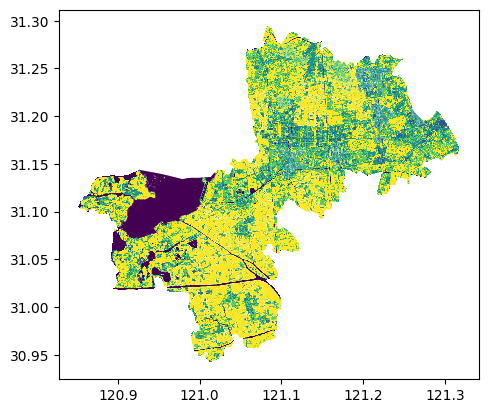

In [13]:
gdf.query('value!=9999').plot(column='value')

In [14]:
gdf = gdf.to_crs(32651)
gdf.query('value!=9999').area.sum()/1000/1000

667.8979950188891

In [15]:
gdf

,value,geometry
0,4.0,"POLYGON ((317524.297 3463769.255, 317575.607 3..."
1,4.0,"POLYGON ((317703.363 3463736.258, 317780.328 3..."
2,4.0,"POLYGON ((317420.638 3463711.288, 317446.293 3..."
3,3.0,"POLYGON ((317830.601 3463674.279, 317856.256 3..."
4,4.0,"POLYGON ((317676.670 3463676.952, 317727.981 3..."
...,...,...
50735,1.0,"POLYGON ((310103.843 3424930.295, 310129.593 3..."
50736,4.0,"POLYGON ((310155.344 3424929.377, 310206.844 3..."
50737,1.0,"POLYGON ((310154.811 3424899.501, 310180.561 3..."
50738,3.0,"POLYGON ((310107.042 3425109.546, 310132.792 3..."
